## SHOTCRETE DESIGN - SPANNING BETWEEN BOLTS IN SANDSTONE

Prepared by: Nick Mirsepassi

Revision = 0


date = 20/08/2025

### Aim
To determine the required shotcrete design to resist failure mechanisms such as adhesion loss, direct shear, flexure, and punching shear failure under a particular rockbolt design layout.

---

### Methodology
This calculation refers to the Barrett and McCreath method as defined in [Ref 2] that characterises the principal collapse mechanisms for a shotcrete support in rock. The methodology considers the shotcrete shell as a plate and the rock bolts as vertical restraints. Therefore, the shotcrete shell is divided into sets of rectangular panels and loaded by the weight of rock wedges resulting in the potential failure mechanisms mentioned above. Figure 1 shows an illustration of said loading mechanism. The calculation also references Vandewalle (2001 & 2005) for the formulation of shotcrete properties as described in [Ref 3] and [Ref 4].

---

### References
- **Ref 1** – Sharaan Resort Basis of Design Report 
- **Ref 2** – Barrett, S.V.L & McCreath, D.R (1995), *Shotcrete Support Design in Blocky Ground: Towards a Deterministic Approach*  
- **Ref 3** – Vandewalle, M (2001), *Tunnelling the World*, Seventh Edition, p.130  
- **Ref 4** – Vandewalle, M (2005), *Tunnelling is an Art; Dramix Steel Fibre at Bekaert*, p.129  
- **Ref 5** – Bertuzzi, R. & Pells, P.J.N. (2002), *Shotcrete Design for Rock Support in Tunnels: Punching and Flexural Behaviour*, Australian Tunnelling Conference Proceedings  
- **Ref 6** – EFNARC (1996), *Specification for Sprayed Concrete* – guidelines on sprayed concrete design and testing  
- **Ref 7** – ITA Working Group 12 (2000), *Guidelines on Sprayed Concrete for Rock Support* – International Tunnelling Association  


---

### Wedge Load
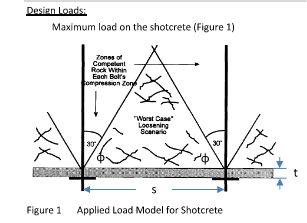

---

### Overbreak Load
Alternatively used for a defined overbreak (block height)


In [1]:
# PYTHON IMPORTS
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Inputs

This notebook uses the following inputs (units in **SI**):

### Rock / Load
- **`gamma_kN_m3`** — unit weight of rock, $\gamma \;[ \text{kN/m}^3 ]$.  
  Used to compute the panel load $W$.
- **`load_model`** — selects how $W$ is calculated:
  - `"wedge"` → Barrett–McCreath wedge load:  
    $$
    W = \gamma \,\frac{\sqrt{6}\,s^3}{6}
    $$
  - `"overbreak"` → slab/overbreak load:  
    $$
    W = \gamma \, h \, s^2
    $$
    (requires `overbreak_m`).
- **`overbreak_m`** — loosened rock thickness $h$ [m]; only used when `load_model="overbreak"`.
- **`q_kPa`** — uniform surcharge load $q$ [kPa].
- **`qw_kPa`** — groundwater pressure $q_w$ [kPa].
- **`LF`** — load factor applied to $W$:  
  $$
  W_f = LF \cdot W
  $$

### Geometry
- **`s0_m`** — reference bolt spacing $s_0$ [m] used for the summary table (plots sweep separately).  
- **`t_m`** — shotcrete thickness $t$ [m].  
- **`c_m`** — plate width (effective support width) $c$ [m]; enters flexural and punching checks.  
- **`CL_m`** — carbonation/cover loss deducted from thickness in flexural capacity [m].  
- **`mc_connected`** — if `True`, a $0.65$ connection factor is applied to the **flexural demand**.

### Adhesion
- **Poor adhesion**: $\sigma_a = \text{sigma\_a\_poor\_MPa}$ [MPa], $a = a_{\text{poor}}$ [m].  
- **Good adhesion**: $\sigma_a = \text{sigma\_a\_good\_MPa}$ [MPa], $a = a_{\text{good}}$ [m].  

Adhesion capacity:  
$$
C_a = 4 \, \sigma_a \, s \, a
$$

### Material Properties & Factors
- **`f_c_MPa`** — compressive strength $f_c$ [MPa].  
- **`f_eq_MPa`** — residual/equivalent flexural strength from beam tests $f_{eq}$ [MPa].  
- **`k_f`** — fibre efficiency factor (dimensionless).  
- **`beta_h`** — punching factor $\beta_h$ (usually $1.0$).  
- **`SRF`** — strength reduction factor applied to capacities.  
- **`sigma_ps_cap_MPa`** — punching stress cap $\sigma_{ps}$ [MPa]; here set to $2.0$.  
- **`m_f`** — flexural connection factor (used in Barrett–McCreath flexural equations).

### Plot Sweep
- **`s_min`**, **`s_max`** — minimum/maximum bolt spacing [m].  
- **`n_pts`** — number of sample points for the sweep.

---

### Note on Flexural Connection
Two modifiers are available:

1. **Demand side (`mc_connected`)**:  
   If `True`, flexural demand is reduced by multiplying by $0.65$.

2. **Equation factor (`m_f`)**:  
   Applied in Barrett–McCreath equations to scale moment demand.

Typical $m_f$ values:
- $m_f \approx 0.14$ → pinned  
- $m_f \approx 0.40$–$0.45$ → intermediate  
- $m_f \approx 0.65$ → near fixed  

These reflect laboratory and field calibration.


In [2]:
# ---------------------------------
# INPUTS
# ---------------------------------
p = dict(
    # Rock / load (set to match the screenshots)
    gamma_kN_m3 = 24.0,       # rock unit weight [kN/m^3]
    load_model  = "wedge",# "wedge" or "overbreak"
    overbreak_m = 0.10,       # h (loosened rock thickness) [m] for overbreak
    q_kPa  = 0.0,             # additional load [kPa] (kN/m^2)
    qw_kPa = 0.0,            # groundwater pressure [kPa]
    LF = 1.5,                 # load factor

    # Geometry
    s0_m = 1.0,              # spacing for summary table [m]
    t_m  = 0.10,              # shotcrete thickness [m]
    c_m  = 0.15,              # plate width [m]
    CL_m = 0.00,             # carbonation/cover loss deducted in flexural capacity [m]
    mc_connected = True,      # if True -> use 0.65 connection factor in flexural demand

    # Adhesion (two cases)
    sigma_a_poor_MPa = 0.15,  # poor adhesion [MPa]
    a_poor_m = 0.05,          # poor bond length [m]
    sigma_a_good_MPa = 0.15,  # good adhesion [MPa]  ← set to match 175 kN at s=1.75 m
    a_good_m = 0.05,          # good bond length [m]

    # Material & factors
    f_c_MPa = 40.0,           # compressive strength [MPa]
    f_eq_MPa = 3.0,           # residual/equivalent flexural strength from beam tests [MPa]
    k_f = 1.0,                # fibre efficiency factor
    beta_h = 1.0,             # (kept for completeness; not used when sigma_ps = tau_ds)
    SRF = 0.6,                # strength reduction factor applied to capacities

    sigma_ps_cap_MPa = 2.0,   # punching stress used in capacity (ultimate); set to 2.0 MPa to match Mathcad
    m_f = 0.65,               # flexural connection factor used in Eqn 4 (0.65 matches the sheet) mc = 1


    # Plot sweep
    s_min = 0.5, s_max = 4.0, n_pts = 60
)



## Derived Material Properties

The following empirical relationships are used to derive shotcrete material strengths from the input compressive strength $f_c$ and beam-test data $f_{eq}$:

- **Flexural strength** ($\sigma_{fl}$)

  $$
  \sigma_{fl} \;=\; \min\!\big(0.6\,\sqrt{f_c},\; f_{eq}\big)
  $$

  This caps the empirical estimate $0.6\sqrt{f_c}$ by the residual/equivalent flexural strength measured in beam tests ($f_{eq}$).  

- **Effective flexural strength** ($\sigma_{fl,eff}$)

  $$
  \sigma_{fl,eff} \;=\; 0.5 \,\sigma_{fl}
  $$

  Used in the Barrett–McCreath formulation for reduced bending resistance.

- **Direct shear strength** ($\tau_{ds}$)

  $$
  \tau_{ds} \;=\; 0.15\,f_c^{1/3} \;+\; \frac{0.12\,k_f\,k_d\,f_{eq}}{0.37}
  $$

  This combines:
  - a compressive strength contribution $0.15\,f_c^{1/3}$  
  - a fibre contribution proportional to $f_{eq}$, scaled by $k_f$ (fibre efficiency) and $k_d$ (depth factor).

- **Punching stress** ($\sigma_{ps}$)

  $$
  \sigma_{ps} \;=\; \tau_{ds}
  $$

  In this implementation, punching capacity is **set equal to direct shear strength**

Punching in fibre-reinforced shotcrete is governed by the same mechanisms as direct shear (diagonal cracking, fibre bridging, aggregate interlock), so setting is both empirically supported and conservative.


In [3]:
# ---------------------------------
# DERIVED MATERIAL PROPERTIES (from f_c, f_eq)
# ---------------------------------
# Flexural: cap by beam test
sigma_fl_MPa_est = 0.6 * math.sqrt(p["f_c_MPa"])
sigma_fl_MPa     = min(sigma_fl_MPa_est, p["f_eq_MPa"])

sigma_fl_eff_MPa = 0.5 * sigma_fl_MPa


# Depth factor
k_d = 1

# Direct shear strength (compressive + fibre term)
tau_ds_MPa = 0.15 * (p["f_c_MPa"] ** (1/3)) + (0.12 * p["k_f"] * k_d * p["f_eq_MPa"]) / 0.37
# Punching stress aligned to Mathcad summary (use same magnitude as shear)
sigma_ps_MPa = tau_ds_MPa


## Helper Functions

The following functions implement the Barrett & McCreath (1995) shotcrete panel design checks.

---

### Rock Load
- **`rock_load_components_kN(s, P)`**  
  Returns the separate load components (all in kN):  
  - Rock overbreak:  
    $$
    W_{\text{rock}} = \gamma \, h \, s^2
    $$
  - Shotcrete self-weight (density $\approx 22.5\,\text{kN/m}^3$):  
    $$
    W_{\text{sc}} = 22.5 \, t \, s^2
    $$
  - Surcharge load:  
    $$
    W_q = q \, s^2
    $$
  - Groundwater pressure:  
    $$
    W_{qw} = q_w \, s^2
    $$

- **`rock_load_kN(s, P)`**  
  Computes total panel load:
  - For `"overbreak"`:  
    $$
    W = W_{\text{rock}} + W_{\text{sc}} + W_q + W_{qw}
    $$
  - For `"wedge"`:  
    $$
    W = \gamma \,\frac{\sqrt{6}\,s^3}{6}
    $$

---

### Adhesion Capacity
- **`adhesion_capacity_kN(s, \sigma_a, a)`**  
  $$
  C_a = 4 \, \sigma_a \, s \, a
  $$
  where $\sigma_a$ is adhesion strength and $a$ is adhesion bond length.  
  (Code converts $\text{MPa} \to \text{kN/m}^2$.)

---

### Direct Shear Capacity
- **`direct_shear_capacity_kN(s, P, \tau_{ds})`**  
  $$
  C_{ds} = 4 \, \tau_{ds} \, s \, t
  $$

---

### Flexural Capacity
- **`flexural_capacity_kNm(s, P, \sigma_{fl})`**  
  Effective thickness reduced for cover loss:  
  $$
  t_{\text{eff}} = \max(t - CL, \, 0)
  $$
  Flexural capacity:  
  $$
  C_{fl} = \sigma_{fl} \, \frac{t_{\text{eff}}^2}{6} \cdot \frac{s}{2}
  $$

---

### Flexural Demand
- **`flexural_demand_kNm(s, P, W)`**  
  Uses only **rock + surcharge** loads (ignores shotcrete self-weight and groundwater, as in Mathcad).  

  $$
  M = \frac{LF \,(W_{\text{rock}}+W_q)\, s}{8}\;\Biggl(\frac{s-0.7c}{s}\Biggr)^2 \cdot m_c
  $$

  where:  
  - $c$ = plate width  
  - $m_c = 0.65$ if `mc_connected=True`, else $1.0$  

---

### Punching Capacity

Two options are available:

1. **Simplified punching** (rarely used here):  
   $$
   C_{ps} = \sigma_{ps} \cdot 4(c+t)\,t
   $$

2. **Equilibrium-based punching** (`punching_capacity_equilibrium_kN`):  
   - Shear resisted outside plate:  
     $$
     V = W \cdot \Bigl(1 - \Bigl(\tfrac{c}{s}\Bigr)^2\Bigr)
     $$
   - Effective perimeter extension:  
     $$
     d = \sqrt{\Bigl(\tfrac{c}{4}\Bigr)^2 + \frac{V}{4\sigma_{ds}}} - \tfrac{c}{4}
     $$
     with $\sigma_{ds} \approx 0.4 f_c$.
   - Punching capacity:  
     $$
     C_{ps} = \sigma_{ps}^{cap} \cdot 4(c+t+d)\,t
     $$

   where $\sigma_{ps}^{cap}$ is **taken as a constant (≈ 2.0 MPa)**.  
   This cap reflects that in practice, punching resistance of fibre-reinforced shotcrete does **not** increase indefinitely with $f_c$, but levels off at a stress governed by aggregate interlock, fibre pull-out, and anchorage around the plate.  
   Using a capped value ensures:
   - **Consistency with beam/shear test data** (observed upper bounds).  
   - **Alignment with field performance** where higher compressive strength does not proportionally raise punching resistance.  
   - **Conservative design** compared to allowing $\sigma_{ps}$ to scale purely with $f_c$.  


---

### Factor of Safety
- **`fos(cap, dem)`**  
  $$
  FoS = \frac{\text{Capacity}}{\text{Demand}}
  $$

- **`pf(x)`**  
  Returns `"PASS"` if $FoS \geq 1.0$, otherwise `"FAIL"`.



In [4]:
# ---------------------------------
# HELPERS
# ---------------------------------
def rock_load_components_kN(s, P):
    """Return rock, self-weight, additional q, and groundwater components (all kN)."""
    W_rock = P["gamma_kN_m3"] * P["overbreak_m"] * s**2
    W_sc   = 22.5 * P["t_m"] * s**2
    W_q    = P.get("q_kPa", 0.0)  * s**2
    W_qw   = P.get("qw_kPa", 0.0) * s**2
    return W_rock, W_sc, W_q, W_qw

def rock_load_kN(s, P):
    """Panel load W. For overbreak, include rock + shotcrete self-weight + q + qw."""
    if P["load_model"].lower() == "overbreak":
        W_rock = P["gamma_kN_m3"] * P["overbreak_m"] * s**2
        W_sc   = 22.5 * P["t_m"] * s**2                 # shotcrete self-weight
        W_q    = P.get("q_kPa", 0.0)  * s**2            # kPa = kN/m^2
        W_qw   = P.get("qw_kPa", 0.0) * s**2
        return W_rock + W_sc + W_q + W_qw
    # Wedge model
    return P["gamma_kN_m3"] * math.sqrt(6.0) * s**3 / 6.0

def adhesion_capacity_kN(s, sigma_a_MPa, a_m):
    return 4.0 * sigma_a_MPa * 1000.0 * s * a_m  # MPa -> kN/m^2

def direct_shear_capacity_kN(s, P, tau_ds):
    return 4.0 * tau_ds * 1000.0 * s * P["t_m"]

def flexural_capacity_kNm(s, P, sigma_fl):
    t_eff = max(P["t_m"] - P.get("CL_m", 0.0), 0.0)  # reduce thickness by CL for capacity
    return sigma_fl * 1000.0 * (t_eff**2)/6.0 * (s/2.0)

def flexural_demand_kNm(s, P, W_kN_unused):
    """
    Flexural moment demand (Barrett & McCreath Eqn 4):
    Use ONLY 'rock + q' components for bending demand, as in the Mathcad sheet.
    """
    W_rock, W_sc, W_q, W_qw = rock_load_components_kN(s, P)
    W_flex = W_rock + W_q  # exclude shotcrete self-weight and groundwater for bending demand
    conn = 0.65 if P.get("mc_connected", True) else 1.0
    shape = ((s - 0.7 * P["c_m"]) / s) ** 2
    return (P["LF"] * W_flex) * s / 8.0 * shape * conn


# --- Equilibrium-based punching ---
def V_shear_kN(W_kN, s_m, c_m):
    return W_kN * (1.0 - (c_m / s_m)**2)

def d_from_equilibrium_m(W_kN, s_m, c_m, sigma_ds_MPa):
    V = V_shear_kN(W_kN, s_m, c_m)    # kN
    return math.sqrt((c_m/4.0)**2 + (V/1000.0)/(4.0*sigma_ds_MPa)) - c_m/4.0

def punching_capacity_equilibrium_kN(P, sigma_ps_MPa_unused, W_kN, s_m):
    # d from equilibrium still uses sigma_ds ≈ 0.4 f_c
    sigma_ds_MPa = 0.4 * P["f_c_MPa"]
    d_m = d_from_equilibrium_m(W_kN, s_m, P["c_m"], sigma_ds_MPa)
    # Mathcad-equivalent perimeter and punching stress for CAPACITY:
    perim = P["c_m"] + P["t_m"] + d_m
    sigma_ps_cap = P.get("sigma_ps_cap_MPa", 2.0)  # <- 2.0 MPa reproduces ~258.7 kN
    Cps = sigma_ps_cap * 1000.0 * 4.0 * perim * P["t_m"]
    return Cps, d_m



def fos(cap, dem): 
    return cap/dem if dem > 0 else float("inf")

## Summary Table at \(s_0\)

At the selected spacing \(s_0\), capacities, demands, and factors of safety are computed as follows.

---

### Applied Loads

- **Component loads** (for `load_model="overbreak"`):
  $$
  W_{\text{rock}} = \gamma\,h\,s_0^2, \qquad
  W_{\text{sc}} = 22.5\,t\,s_0^2, \qquad
  W_q = q\,s_0^2, \qquad
  W_{qw} = q_w\,s_0^2.
  $$
- **Total panel load**:
  $$
  W \;=\; W_{\text{rock}} + W_{\text{sc}} + W_q + W_{qw}, \qquad
  W_f \;=\; LF \cdot W.
  $$
- **Flexural load component** (used **only** for bending demand, per Mathcad convention):
  $$
  W_{\text{flex}} \;=\; W_{\text{rock}} + W_q.
  $$

---

### Adhesion Capacity (two cases, from inputs)

- **Capacity**:
  $$
  C_a \;=\; 4\,\sigma_a\,s_0\,a.
  $$
  Two cases are evaluated using the input pairs: “poor” and “good”.

---

### Direct Shear Capacity

- **Capacity**:
  $$
  C_{ds} \;=\; 4\,\tau_{ds}\,s_0\,t.
  $$

---

### Flexure

- **Effective thickness (cover loss)**:
  $$
  t_{\text{eff}} \;=\; \max(t - CL,\;0).
  $$
- **Capacity** (with effective flexural strength):
  $$
  C_{fl} \;=\; \sigma_{fl,eff}\;\frac{t_{\text{eff}}^2}{6}\;\frac{s_0}{2}.
  $$
- **Demand** (Barrett–McCreath Eqn 4 form):
  $$
  M_d \;=\; \frac{LF \; W_{\text{flex}} \; s_0}{8}
  \left(\frac{s_0 - 0.7\,c}{s_0}\right)^2
  \cdot m_c,
  \qquad
  m_c = \begin{cases}
  0.65, & \text{if } \texttt{mc\_connected}=\text{True} \\
  1.00, & \text{otherwise}
  \end{cases}
  $$
The reported unfactored moment is:

$$
M_o = \frac{M_d}{LF}
$$


---

### Punching Shear (Equilibrium-Based)

- **Shear outside the plate**:
  $$
  V \;=\; W \left(1 - \left(\frac{c}{s_0}\right)^2\right).
  $$
- **Perimeter extension from equilibrium** (with \(\sigma_{ds}\approx 0.4\,f_c\)):
  $$
  d \;=\; \sqrt{\left(\frac{c}{4}\right)^2 + \frac{V}{4\,\sigma_{ds}}} \;-\; \frac{c}{4}.
  $$
- **Capacity** (perimeter taken as \(4(c+t+d)\)):
  $$
  C_{ps} \;=\; \sigma_{ps}^{\text{cap}} \cdot 4\,(c+t+d)\,t.
  $$

  **Justification for \(\sigma_{ps}^{\text{cap}}\) as a constant (≈ 2.0 MPa):**  
  In fibre-reinforced shotcrete, punching resistance is governed by aggregate interlock, fibre pull-out, and local confinement around the plate; these mechanisms do **not** scale linearly with \(f_c\) at higher strengths. Adopting a capped \(\sigma_{ps}^{\text{cap}}\) is an empirically conservative practice aligned with beam/shear test plateaus and field observations, preventing unrealistically high punching estimates at high \(f_c\).

---

## Factor of Safety

The factor of safety is defined as:

$$
FoS = \frac{Capacity \cdot SRF}{Demand \cdot LF}
$$


---

A mechanism is marked **PASS** if greater than 1, otherwise **FAIL**.





In [5]:
# ---------------------------------
# SUMMARY TABLE at s0 (ultimate + factored on both sides)
# ---------------------------------
s0  = p["s0_m"]
LF  = p["LF"]

W0  = rock_load_kN(s0, p)       # ultimate load
W0f = LF * W0                   # factored load

Wrock, Wsc, Wq, Wqw = rock_load_components_kN(s0, p)
Wflex = Wrock + Wq
print(f"W components @ s0: rock={Wrock:.3f} kN, self-weight={Wsc:.3f} kN, q={Wq:.3f} kN, qw={Wqw:.3f} kN")
print(f"W_total={W0:.3f} kN | W_flex (rock+q)={Wflex:.3f} kN")

Ca_poor = adhesion_capacity_kN(s0, p["sigma_a_poor_MPa"], p["a_poor_m"])
Ca_good = adhesion_capacity_kN(s0, p["sigma_a_good_MPa"], p["a_good_m"])
Cds     = direct_shear_capacity_kN(s0, p, tau_ds_MPa)
Cfl     = flexural_capacity_kNm(s0, p, sigma_fl_eff_MPa)
Md      = flexural_demand_kNm(s0, p, W0)   # this already includes LF by definition
Mo      = Md / LF                          # ultimate (unfactored) moment
Cps, d_m = punching_capacity_equilibrium_kN(p, sigma_ps_MPa, W0, s0)

SRF = p["SRF"]

summary = pd.DataFrame([
    ["Adhesion (poor)",   Ca_poor, SRF*Ca_poor, W0,  W0f,  fos(SRF*Ca_poor, W0f)],
    ["Adhesion (good)",   Ca_good, SRF*Ca_good, W0,  W0f,  fos(SRF*Ca_good, W0f)],
    ["Direct Shear",      Cds,     SRF*Cds,     W0,  W0f,  fos(SRF*Cds,     W0f)],
    ["Flexure (classic)", Cfl,     SRF*Cfl,     Mo,  Md,   fos(SRF*Cfl,     Md )],
    ["Punching",          Cps,     SRF*Cps,     W0,  W0f,  fos(SRF*Cps,     W0f)],
], columns=[
    "Check",
    "Capacity (kN or kN·m) - Ultimate",
    "Capacity (kN or kN·m) - Factored",
    "Demand (kN or kN·m) - Working",
    "Demand (kN or kN·m) - Factored",
    "FoS [-]"  # based on Factored capacity vs Factored demand
])

print(
    f"Derived strengths: f_c={p['f_c_MPa']:.1f} MPa | "
    f"sigma_fl={sigma_fl_MPa:.2f} MPa (est {sigma_fl_MPa_est:.2f}) | "
    f"tau_ds={tau_ds_MPa:.3f} MPa | sigma_ps={sigma_ps_MPa:.3f} MPa"
)
print(
    f"s0={s0:.2f} m | W={W0:.3f} kN (factored {W0f:.3f}) | "
    f"Mo={Mo:.3f} kN·m (factored Md={Md:.3f}) | d={d_m*1000:.1f} mm | SRF={SRF}"
)

display(summary.style.format({
    "Capacity (kN or kN·m) - Ultimate": "{:.3f}",
    "Capacity (kN or kN·m) - Factored": "{:.3f}",
    "Demand (kN or kN·m) - Ultimate": "{:.3f}",
    "Demand (kN or kN·m) - Factored": "{:.3f}",
    "FoS [-]": "{:.2f}",
}))

W components @ s0: rock=2.400 kN, self-weight=2.250 kN, q=0.000 kN, qw=0.000 kN
W_total=9.798 kN | W_flex (rock+q)=2.400 kN
Derived strengths: f_c=40.0 MPa | sigma_fl=3.00 MPa (est 3.79) | tau_ds=1.486 MPa | sigma_ps=1.486 MPa
s0=1.00 m | W=9.798 kN (factored 14.697) | Mo=0.156 kN·m (factored Md=0.234) | d=1.9 mm | SRF=0.6


,Check,Capacity (kN or kN·m) - Ultimate,Capacity (kN or kN·m) - Factored,Demand (kN or kN·m) - Working,Demand (kN or kN·m) - Factored,FoS [-]
0,Adhesion (poor),30.000,18.000,9.797959,14.697,1.22
1,Adhesion (good),30.000,18.000,9.797959,14.697,1.22
2,Direct Shear,594.386,356.632,9.797959,14.697,24.27
3,Flexure (classic),1.250,0.750,0.156200,0.234,3.20
4,Punching,201.556,120.934,9.797959,14.697,8.23


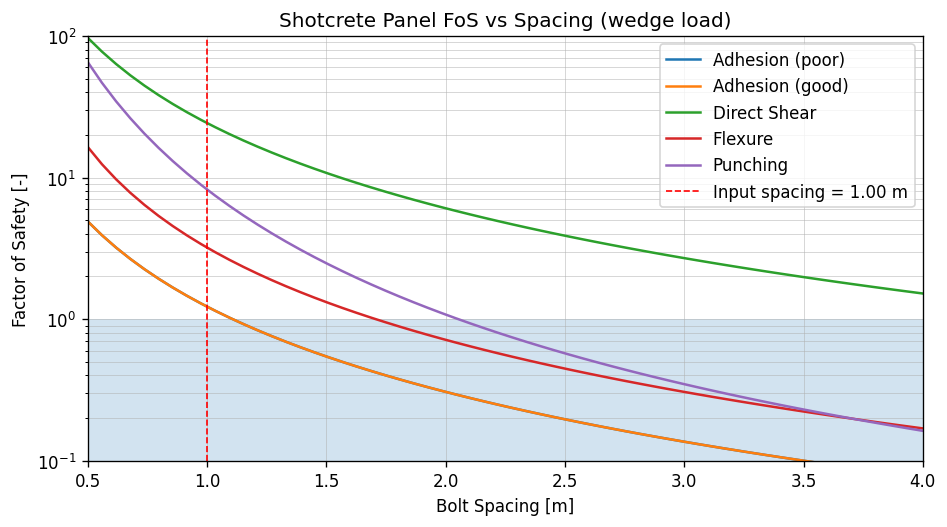

In [6]:
# ---------------------------------
# FoS vs spacing plot (uses same conventions)
# ---------------------------------
s_vals = np.linspace(p["s_min"], p["s_max"], p["n_pts"])
fos_adh_poor, fos_adh_good, fos_ds, fos_fl, fos_ps = [], [], [], [], []

for s in s_vals:
    W  = rock_load_kN(s, p)
    Wf = p["LF"] * W

    Ca_p = adhesion_capacity_kN(s, p["sigma_a_poor_MPa"], p["a_poor_m"])
    Ca_g = adhesion_capacity_kN(s, p["sigma_a_good_MPa"], p["a_good_m"])
    Cds_ = direct_shear_capacity_kN(s, p, tau_ds_MPa)
    Cfl_  = flexural_capacity_kNm(s, p, sigma_fl_eff_MPa)
    Md_  = flexural_demand_kNm(s, p, W)
    Cps_, _ = punching_capacity_equilibrium_kN(p, sigma_ps_MPa, W, s)

    fos_adh_poor.append(SRF*Ca_p / Wf)
    fos_adh_good.append(SRF*Ca_g / Wf)
    fos_ds.append(SRF*Cds_ / Wf)
    fos_fl.append(SRF*Cfl_ / Md_ if Md_ > 0 else np.nan)
    fos_ps.append(SRF*Cps_ / Wf)

plt.figure(figsize=(8,4.5), dpi=120)
plt.plot(s_vals, fos_adh_poor, label="Adhesion (poor)")
plt.plot(s_vals, fos_adh_good, label="Adhesion (good)")
plt.plot(s_vals, fos_ds,  label="Direct Shear")
plt.plot(s_vals, fos_fl,  label="Flexure")
plt.plot(s_vals, fos_ps,  label="Punching")

# Highlight FoS < 1 region
plt.fill_between(s_vals, 0.0, 1.0, alpha=0.2)

# Add vertical line at input spacing
s0 = p["s0_m"]
plt.axvline(s0, color="red", linestyle="--", linewidth=1, label=f"Input spacing = {s0:.2f} m")

# Axis scaling and labels
plt.yscale("log")
plt.ylim(0.1, 100)
plt.xlim(s_vals.min(), s_vals.max())
plt.grid(True, which="both", alpha=0.6, linewidth=0.5)
plt.xlabel("Bolt Spacing [m]")
plt.ylabel("Factor of Safety [-]")

# Title and legend
title_suffix = "(overbreak load)" if p["load_model"].lower()=="overbreak" else "(wedge load)"
plt.title(f"Shotcrete Panel FoS vs Spacing {title_suffix}")
plt.legend()
plt.tight_layout()
plt.show()


